<a href="https://colab.research.google.com/github/starkjiang/TrAC-RL/blob/main/m4_RL_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proximal Policy Optimization for Lunar Lander

In this tutorial, we will implement Proximal Policy Optimization (PPO) for the environment of Lunar Lander in OpenAI `gym`. The Lunar Lander environment is part of [Box2D environments](https://www.gymlibrary.dev/environments/box2d/).

**Description of Lunar Lander**

This environment is a classic rocket trajectory optimization problem. According to Pontryagin's maximum principle, it is optimal to fire the engine at full throttle or turn it off. This is the reason why this environment has discrete actions: engine on or off. There are two environment versions: discrete or continuous. The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector. Landing outside of the landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt.

**Action Space**

There are four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

**Observation Space**

The state is an 8-dimensional vector: the coordinates of the lander in `x` & `y`, its linear velocities in `x` & `y`, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

**Rewards**

Reward for moving from the top of the screen to the landing pad and coming to rest is about 100-140 points. If the lander moves away from the landing pad, it loses reward. If the lander crashes, it receives an additional -100 points. If it comes to rest, it receives an additional +100 points. Each leg with ground contact is +10 points. Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame. Solved is 200 points.

**Starting State**

The lander starts at the top center of the viewport with a random initial force applied to its center of mass.

**Episode Termination**

The episode finishes if:

1.   the lander crashes (the lander body gets in contact with the moon);
2.   the lander gets outside of the viewport `(x` coordinate is greater than 1);
3.   the lander is not awake. From the Box2D docs, a body which is not awake is a body which doesn't move and doesn't collide with any other body.


In [ ]:
"""This script is for showcasing the PPO algorithm with Lunar Lander
environment. You need to install OpenAI gymnasium first and relevant packages"""
!pip install swig
!pip install gymnasium[box2d]
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379491 sha256=df0bc5146dd5252337abbda7badd3bdcb0ade04ab69b5b8c8c7a3ce54161e7ac
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [ ]:
# Create train and test environments.

train_env = gym.make('LunarLander-v3')
test_env = gym.make('LunarLander-v3')

In [ ]:
# Set random seed.
SEED = 1234
train_env.reset(seed=SEED)
test_env.reset(seed=SEED+1)
np.random.seed(SEED);
torch.manual_seed(SEED);

In [ ]:
# Create base MLP model.
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.5):
        super().__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc_3(x)
        return x

In [ ]:
# Create actor and critic networks based on the base MLP model.
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()

        self.actor = actor
        self.critic = critic

    def forward(self, state):

        action_pred = self.actor(state)
        value_pred = self.critic(state)

        return action_pred, value_pred

In [ ]:
# Define dimensions for input, hidden and output layers.
INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = train_env.action_space.n
actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)
policy = ActorCritic(actor, critic)

In [ ]:
# Initialize the weights.
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)
policy.apply(init_weights)

ActorCritic(
  (actor): MLP(
    (fc_1): Linear(in_features=8, out_features=128, bias=True)
    (fc_2): Linear(in_features=128, out_features=128, bias=True)
    (fc_3): Linear(in_features=128, out_features=4, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (critic): MLP(
    (fc_1): Linear(in_features=8, out_features=128, bias=True)
    (fc_2): Linear(in_features=128, out_features=128, bias=True)
    (fc_3): Linear(in_features=128, out_features=1, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
# Get learning rate and optimizer.
LEARNING_RATE = 0.01
optimizer = optim.Adam(policy.parameters(), lr = LEARNING_RATE)

In [ ]:
# Define the function for training the agent.
def train(env, policy, optimizer, discount_factor, ppo_steps, ppo_clip):
    """Train the RL agent."""
    policy.train()

    states = []
    actions = []
    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0

    state, _ = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        #Append state here, not after we get the next state from env.step()
        states.append(state)

        # Get the action and value.
        action_pred, value_pred = policy(state)
        # Turn action to probability.
        action_prob = F.softmax(action_pred, dim = -1)
        # Get the categorical values.
        dist = distributions.Categorical(action_prob)

        # Sample an action.
        action = dist.sample()

        # Calculate the log of probability of taking this action.
        log_prob_action = dist.log_prob(action)

        # Apply the action.
        state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        actions.append(action)
        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)

        episode_reward += reward

    states = torch.cat(states)
    actions = torch.cat(actions)
    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)

    returns = calculate_returns(rewards, discount_factor)
    advantages = calculate_advantages(returns, values)

    policy_loss, value_loss = update_policy(
        policy,
        states,
        actions,
        log_prob_actions,
        advantages,
        returns,
        optimizer,
        ppo_steps,
        ppo_clip
    )

    return policy_loss, value_loss, episode_reward

In [ ]:
def calculate_returns(rewards, discount_factor, normalize = True):
    """Calculate the returns."""
    returns = []
    R = 0

    for r in reversed(rewards):
        # We use a backward manner to calculate returns.
        R = r + R * discount_factor
        returns.insert(0, R)

    returns = torch.tensor(returns)

    if normalize:
        returns = (returns - returns.mean()) / returns.std()

    return returns

In [ ]:
def calculate_advantages(returns, values, normalize = True):
    """Calculate the advantages."""
    advantages = returns - values

    if normalize:

        advantages = (advantages - advantages.mean()) / advantages.std()

    return advantages

# Proximal Policy Optimization (PPO)

TRPO: [Schulman, John, et al. "Trust region policy optimization." International conference on machine learning. PMLR, 2015.](https://proceedings.mlr.press/v37/schulman15.pdf)

PPO: [Schulman, John, et al. "Proximal policy optimization algorithms." arXiv preprint arXiv:1707.06347 (2017)](https://arxiv.org/pdf/1707.06347)

There are two kinds of algorithms of PPO: PPO-Penalty and PPO-Clip. Here, we'll implement PPO-clip version.

TRPO computes the gradients with a complex second-order method. On the other hand, PPO tries to solve the problem with a first-order methods that keep new policies close to old. To simplify the surrogate objective, let $r(\theta)$ denote the probability ratio such that

$$ L^{CPI}(\theta) = \hat {\mathbb{E}}_t \left [ {\pi_\theta(a_t|s_t) \over \pi_{\theta_{old}}(a_t|s_t)} \hat A_t\right] = \hat {\mathbb{E}}_t \left [ r_t(\theta) \hat A_t \right ].$$

The objective is penalized further away from $r_t(\theta)$

$$ L^{CLIP}(\theta)=\hat {\mathbb{E}}_t \left [ \min(r_t(\theta) \hat A_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat A_t) \right ] $$

If the advantage is positive, the objective will increase. As a result, the action becomes more likely. If advantage is negative, the objective will decrease. AS a result, the action becomes less likely.

In [ ]:
def update_policy(
    policy,
    states,
    actions,
    log_prob_actions,
    advantages,
    returns,
    optimizer,
    ppo_steps,
    ppo_clip,
):
    """Update the policy network."""
    total_policy_loss = 0
    total_value_loss = 0

    advantages = advantages.detach()
    log_prob_actions = log_prob_actions.detach()
    actions = actions.detach()

    for _ in range(ppo_steps):

        #Get new log prob of actions for all input states
        action_pred, value_pred = policy(states)
        value_pred = value_pred.squeeze(-1)
        action_prob = F.softmax(action_pred, dim = -1)
        dist = distributions.Categorical(action_prob)

        # New log prob using old actions.
        new_log_prob_actions = dist.log_prob(actions)
        # Calculate the policy ratio.
        policy_ratio = (new_log_prob_actions - log_prob_actions).exp()
        # Calculate the first policy loss: called conservative policy iteration.
        policy_loss_1 = policy_ratio * advantages
        # Calculate the clip policy loss.
        policy_loss_2 = torch.clamp(
            policy_ratio, min = 1.0 - ppo_clip, max = 1.0 + ppo_clip
        ) * advantages
        # Get the minimum one.
        policy_loss = - torch.min(policy_loss_1, policy_loss_2).sum()
        # Calculate the value loss.
        value_loss = F.smooth_l1_loss(returns, value_pred).sum()

        optimizer.zero_grad()

        policy_loss.backward()
        value_loss.backward()

        optimizer.step()

        total_policy_loss += policy_loss.item()
        total_value_loss += value_loss.item()

    return total_policy_loss / ppo_steps, total_value_loss / ppo_steps

In [ ]:
def evaluate(env, policy):
    """Evaluate the policy network."""
    policy.eval()

    rewards = []
    done = False
    episode_reward = 0

    state, _ = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():

            action_pred, _ = policy(state)

            action_prob = F.softmax(action_pred, dim = -1)

        action = torch.argmax(action_prob, dim = -1)

        state, reward, terninated, truncated, _ = env.step(action.item())
        done = terninated or truncated

        episode_reward += reward

    return episode_reward

In [ ]:
MAX_EPISODES = 500
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 475
PRINT_EVERY = 10
PPO_STEPS = 5
PPO_CLIP = 0.2

train_rewards = []
test_rewards = []

for episode in range(1, MAX_EPISODES+1):

    policy_loss, value_loss, train_reward = train(
        train_env,
        policy,
        optimizer,
        DISCOUNT_FACTOR,
        PPO_STEPS,
        PPO_CLIP,
    )

    test_reward = evaluate(test_env, policy)

    train_rewards.append(train_reward)
    test_rewards.append(test_reward)

    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    # mean_train_rewards = np.mean(train_rewards)
    # mean_test_rewards = np.mean(test_rewards)

    if episode % PRINT_EVERY == 0:

        print(
            f'| Episode: {episode:3} |'
            f'Mean Train Rewards: {mean_train_rewards:5.1f} |'
            f'Mean Test Rewards: {mean_test_rewards:5.1f} |'
        )

    if mean_test_rewards >= REWARD_THRESHOLD:

        print(f'Reached reward threshold in {episode} episodes')

        break

| Episode:  10 |Mean Train Rewards: -279.8 |Mean Test Rewards: -918.8 |
| Episode:  20 |Mean Train Rewards: -212.2 |Mean Test Rewards: -737.2 |
| Episode:  30 |Mean Train Rewards: -177.5 |Mean Test Rewards: -637.8 |
| Episode:  40 |Mean Train Rewards: -226.6 |Mean Test Rewards: -728.6 |
| Episode:  50 |Mean Train Rewards: -325.8 |Mean Test Rewards: -750.7 |
| Episode:  60 |Mean Train Rewards: -366.6 |Mean Test Rewards: -821.3 |
| Episode:  70 |Mean Train Rewards: -423.1 |Mean Test Rewards: -723.4 |
| Episode:  80 |Mean Train Rewards: -468.6 |Mean Test Rewards: -752.4 |
| Episode:  90 |Mean Train Rewards: -456.4 |Mean Test Rewards: -790.2 |
| Episode: 100 |Mean Train Rewards: -444.5 |Mean Test Rewards: -824.2 |
| Episode: 110 |Mean Train Rewards: -503.3 |Mean Test Rewards: -917.1 |
| Episode: 120 |Mean Train Rewards: -655.0 |Mean Test Rewards: -845.1 |
| Episode: 130 |Mean Train Rewards: -751.7 |Mean Test Rewards: -803.7 |
| Episode: 140 |Mean Train Rewards: -691.7 |Mean Test Rewards: -

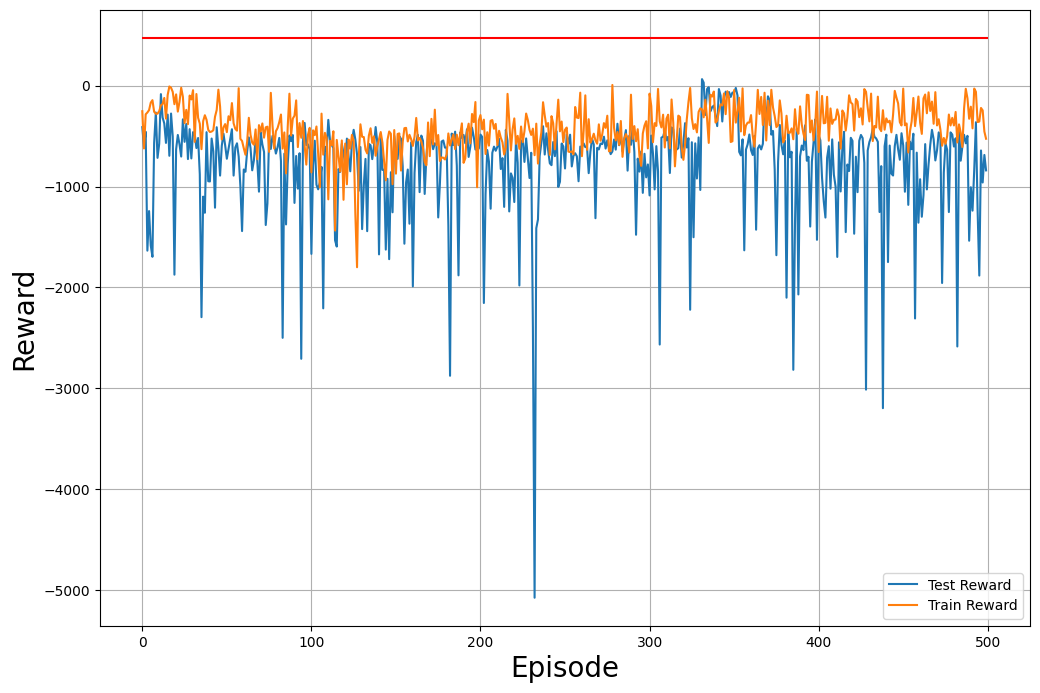

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()